In [1]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import sys
sys.path.append(("/home/ipausers/lin/Desktop/AMF/AMFtrack"))
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import json
import imageio
import logging
import cv2
from skimage.measure import profile_line

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    Node,
    Edge,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    plot_full,
    reconstruct_image_from_general,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_width,
    plot_full,
)

from amftrack.util.sys import get_current_folders, update_plate_info, test_path
from amftrack.util.plot import show_image
from amftrack.util.sys import storage_path
from amftrack.util.geometry import (
    generate_index_along_sequence,
    centered_bounding_box,
    expand_segment,
    get_section_segment,
    compute_factor,
    generate_index_along_sequence,
    distance_point_pixel_line,
    get_closest_lines,
    get_closest_line_opt,
    intersect_rectangle,
    is_overlapping,
    get_overlap,
    format_region,
    is_in_bounding_box,
    get_bounding_box,
    centered_bounding_box,
)
from amftrack.util.image_analysis import (
    find_transformation,
    get_transformation,
    reverse_transformation,
    convert_to_micrometer,
    find_image_index,
    is_in_image,
    extract_inscribed_rotated_image,
    is_negative_similarity,
    find_similarity,
    find_scaling_factor,
)
from amftrack.util.geometry import generate_index_along_sequence
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    compute_edge_width_profile,
    extract_section_profiles_for_edge,
)

2023-02-19 22:38:01.377708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 22:38:01.480385: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ipausers/lin/Desktop/Kai/Graduation-Project/graduation/lib/python3.8/site-packages/cv2/../../lib64:
2023-02-19 22:38:01.480405: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-19 22:38:06.302831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load 

In [4]:
select_exp = "/home/ipausers/lin/Desktop/Kai/Graduation-Project/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
label_df = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="Labelme",index_col=0)
label_df = label_df.iloc[:,1:]
label_df

,top,R,R2,D,D2,D3,M,M2,M3,L,...,L3,L4,L5,LT,RT,LM,LM2,LD,MT,MD
pos3,5.466252,3.360181,NaN,5.978320,NaN,NaN,NaN,NaN,NaN,3.329234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos4,3.890178,NaN,NaN,4.738162,NaN,NaN,4.940548,4.970713,NaN,3.110446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos5,3.867490,2.815162,NaN,4.811456,NaN,NaN,4.886012,4.084507,NaN,3.271058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos6,5.118606,3.163404,NaN,4.191390,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos7,4.057369,3.093466,NaN,5.192105,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pos60,8.546125,7.723462,NaN,6.794172,NaN,NaN,8.260645,7.327132,NaN,5.528969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos61,NaN,3.494587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.295571,...,NaN,NaN,NaN,2.635567,NaN,NaN,NaN,NaN,2.809692,2.938713
pos62,3.247844,4.441835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.304565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos63,NaN,4.753152,NaN,4.250022,NaN,NaN,NaN,NaN,NaN,4.972553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
label_df.iloc[0].dropna()

top    5.466252
R      3.360181
D      5.978320
L      3.329234
Name: pos3, dtype: float64

In [6]:
res = []
for i in range(len(label_df)):
    row = label_df.iloc[i].dropna().sort_values(ascending=False)
    if len(row) == 3:
        row = (row/2)**3
        main, daughter1, daughter2 = row[0], row[1], row[2]
        res.append(main-daughter1 - daughter2)

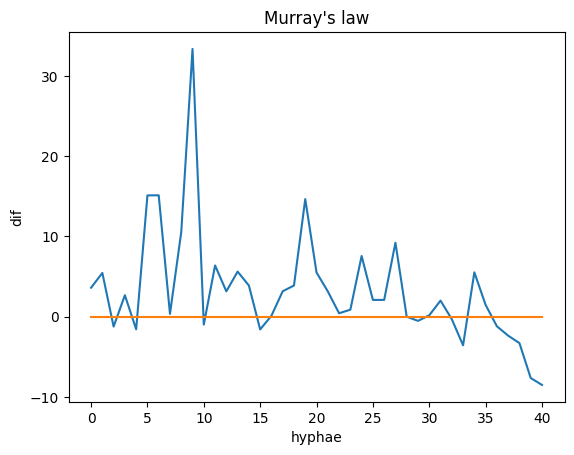

In [8]:
plt.plot(res)
plt.plot((0,40),(0,0),"-")
plt.title("Murray's law")
plt.xlabel("hyphae")
plt.ylabel("dif")
plt.show()

In [9]:
# From pos1 to pos27 along one hyphae.
# From pos 28 to pos 60 along another hyphae.
res = {}
for i in range(len(label_df)):
    row = label_df.iloc[i].dropna().sort_values(ascending=False)
    if len(row) == 3:
        pos = int(row.name[3:])
        row = round((row/2)**3)
        main, daughter1, daughter2 = row[0], row[1], row[2]
        res[pos] = (main,row.index[0])

In [10]:
# The xlsx file might not be the same as all of the data in experiment Labelme ground truth I extract.
# Because some data point did not have node or not have edge
# To avoid this problem, that's try the original ground truth and ignore the node and edge.

In [11]:
def get_labelme_segments(directory):
    # https://github.com/wkentaro/labelme
    labelme_dict = {}
    def load_labelmefile(file):
        with open(file) as r:
            return json.load(r)
    for labelmefiles in os.listdir(directory):
        if ".json" in labelmefiles:
            labelme_path = os.path.join(directory,labelmefiles)
            labelmefile = load_labelmefile(labelme_path)
            for shape in labelmefile["shapes"]:
                if shape["label"] in labelme_dict.keys():
                    labelme_dict[shape["label"]].append(shape["points"])
                else:
                    labelme_dict[shape["label"]]= [shape["points"]]
    return labelme_dict
segment = get_labelme_segments("/home/ipausers/lin/Desktop/Kai/Graduation-Project/Experiment/Labelme/Plate705_20221116")
import numpy as np
def compute_width_from_segment(segment):
    def convert_to_micrometer(pixel_length,camera_res=3.45, magnification=50):
        """
        Converts pixels into micrometers, based on the magnification of the microscope.
        """
        return pixel_length * camera_res / magnification
    width_dict = {}
    width_std_dict = {}
    for key in segment.keys():
        widths = []
        for point1,point2 in segment[key]:
            point1 = np.array(point1)
            point2 = np.array(point2)
            width = convert_to_micrometer(np.linalg.norm(point1 - point2), magnification=50)
            widths.append(width)
        width_dict[key] = np.mean(widths)
        width_std_dict[key] = np.std(widths)
    return width_dict, width_std_dict
width_dict,width_std_dict= compute_width_from_segment(segment)

In [12]:
labelme_df = pd.DataFrame.from_dict(width_dict,orient='index')
labelme_df = labelme_df.sort_index()
labelme_df

,0
Pos10_D,4.821696
Pos10_R,2.988055
Pos10_top,5.014801
Pos11_D,6.795375
Pos11_R,3.283796
...,...
Pos8_L,2.334908
Pos8_top,4.440601
Pos9_D,4.823713
Pos9_R,2.812058


In [14]:
select_exp = "/home/ipausers/lin/Desktop/Kai/Graduation-Project/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
exp_df = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="11.16",skiprows=1,index_col=0,header=0)
for index, value in labelme_df.iterrows():
    if len(index.split("_")) == 2:
        pos, direction = index.split("_")
        exp_df.at[pos.lower(),direction]=value[0]
    if len(index.split("_")) == 3:
        pos, direction,direction2 = index.split("_")
        exp_df.at[pos.lower(),direction+direction2]=value[0]
exp_df = exp_df.iloc[:,9:]

In [15]:
main_res = {}
daughter1_res={}
daughter2_res={}
for i in range(len(exp_df)):
    row = exp_df.iloc[i].dropna().sort_values(ascending=False)
    if len(row) == 3:
        pos = int(row.name[3:])
        main, daughter1, daughter2 = row[0], row[1], row[2]
        main_res[pos] = (main,row.index[0])
        daughter1_res[pos] = (daughter1,row.index[1])
        daughter2_res[pos] = (daughter2,row.index[2])

In [16]:
# From pos 1 to pos27 along one hyphae.
# From pos 28 to pos 60 along another hyphae.
# From pos 61 to pos 62 along another hyphae. However, I cannot know what is the correct growth direction.
# From pos 6
# the largest width for pos6,pos10,pos14,pos15,pos24,pos53 are not at the bottom part.
main_res

{1: (5.335140673465174, 'focus1D'),
 2: (5.096729871593014, 'D'),
 6: (5.118605562865291, 'top'),
 7: (5.192105321266606, 'D'),
 8: (4.487475152669089, 'D'),
 9: (4.823713368638635, 'D'),
 10: (5.014801085370462, 'top'),
 11: (6.795374544159621, 'D'),
 12: (6.976917743235791, 'D'),
 13: (6.339169606731782, 'D'),
 14: (6.583453526998798, 'top'),
 15: (7.637525601085848, 'top'),
 16: (5.729746780870368, 'D'),
 17: (6.16119729702714, 'D'),
 19: (6.229526767127777, 'D'),
 22: (7.1103384349532766, 'D'),
 24: (5.680538549130845, 'top'),
 25: (6.678539152288823, 'D'),
 28: (4.742852366984828, 'D'),
 29: (7.021948158393189, 'D'),
 31: (6.1414489882410095, 'D'),
 32: (4.758393941850271, 'D'),
 33: (4.308989903813287, 'D'),
 36: (4.291359979486507, 'D'),
 37: (4.030576567271207, 'D'),
 38: (5.9175671981595075, 'D'),
 42: (4.443552429130558, 'D'),
 45: (5.022630878468604, 'D'),
 46: (3.9744255583781545, 'D'),
 47: (4.1476846649118455, 'D'),
 49: (3.66291189735178, 'D'),
 50: (4.159818600289128, '

In [18]:
def get_hypha_info(res_dict,set_range):
    hyphae_value = []
    hyphae_key = []
    for key,value in res_dict.items():
        if set_range[0]<= key <= set_range[1]:
            hyphae_value.append(value[0])
            hyphae_key.append(key)
    return np.array(hyphae_value), hyphae_key

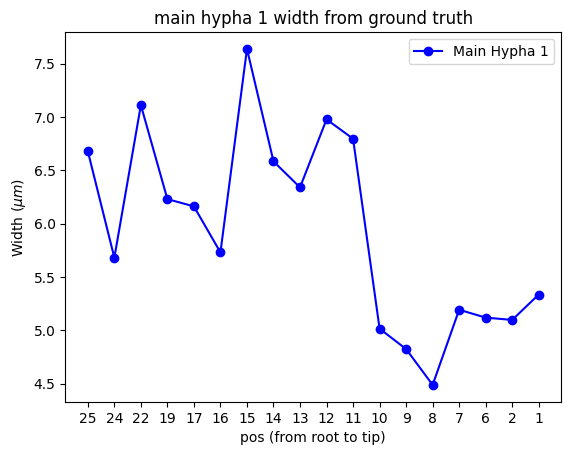

In [19]:
# From pos 1 to pos27 along one hyphae.
# From pos 28 to pos 60 along another hyphae.
mhv1, mhk1 = get_hypha_info(main_res,[1,27])
mhv1 = np.flip(mhv1)
mhk1.reverse()
plt.plot(mhv1, "ob-",label="Main Hypha 1")
plt.xticks(np.arange(0,len(mhk1),1),labels=mhk1)
plt.ylabel("Width ($\mu m$)")
plt.xlabel("pos (from root to tip)")
plt.title("main hypha 1 width from ground truth")
plt.legend()
# plt.savefig("plot_data/murray's rule/main hypha 1 width from ground truth.png")

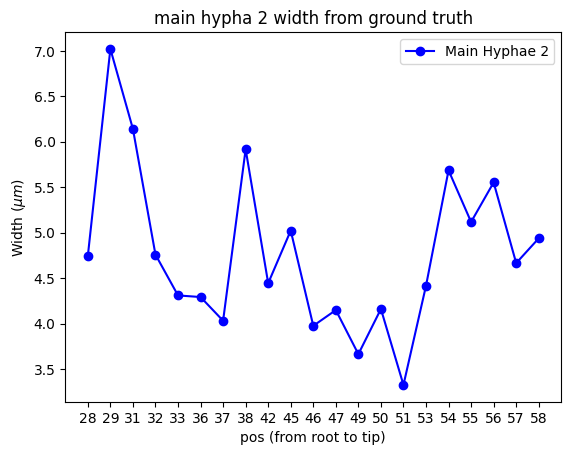

In [20]:
mhv2, mhk2 = get_hypha_info(main_res,[28,60])
plt.plot(mhv2,"ob-", label="Main Hyphae 2")
plt.xticks(np.arange(0,len(mhk2),1),labels=mhk2)
plt.ylabel("Width ($\mu m$)")
plt.xlabel("pos (from root to tip)")
plt.title("main hypha 2 width from ground truth")
plt.legend()
# plt.savefig("plot_data/murray's rule/main hypha 2 width from ground truth.png")

In [79]:
main_res,daughter1_res,daughter2_res

({1: (5.335140673465174, 'focus1D'),
  2: (5.096729871593014, 'D'),
  6: (5.118605562865291, 'top'),
  7: (5.192105321266606, 'D'),
  8: (4.487475152669089, 'D'),
  9: (4.823713368638635, 'D'),
  10: (5.014801085370462, 'top'),
  11: (6.795374544159621, 'D'),
  12: (6.976917743235791, 'D'),
  13: (6.339169606731782, 'D'),
  14: (6.583453526998798, 'top'),
  15: (7.637525601085848, 'top'),
  16: (5.729746780870368, 'D'),
  17: (6.16119729702714, 'D'),
  19: (6.229526767127777, 'D'),
  22: (7.1103384349532766, 'D'),
  24: (5.680538549130845, 'top'),
  25: (6.678539152288823, 'D'),
  28: (4.742852366984828, 'D'),
  29: (7.021948158393189, 'D'),
  31: (6.1414489882410095, 'D'),
  32: (4.758393941850271, 'D'),
  33: (4.308989903813287, 'D'),
  36: (4.291359979486507, 'D'),
  37: (4.030576567271207, 'D'),
  38: (5.9175671981595075, 'D'),
  42: (4.443552429130558, 'D'),
  45: (5.022630878468604, 'D'),
  46: (3.9744255583781545, 'D'),
  47: (4.1476846649118455, 'D'),
  49: (3.66291189735178, '

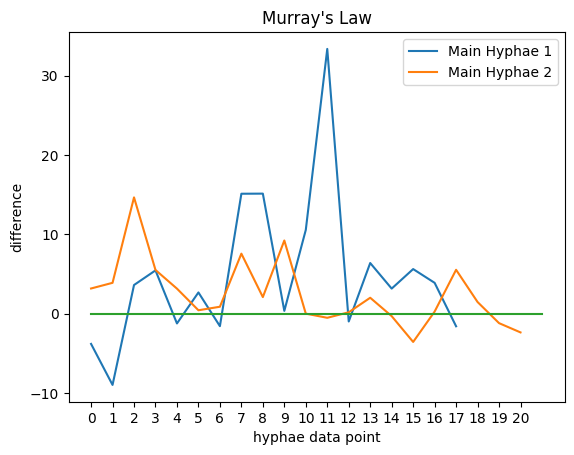

In [25]:
def murray(mh1,dh1,dh2):
    return (mh1/2)**3-(dh1/2)**3-(dh2/2)**3
plt.plot(murray(get_hypha_info(main_res,[1,27])[0],get_hypha_info(daughter1_res,[1,27])[0],get_hypha_info(daughter2_res,[1,27])[0]),label="Main Hyphae 1")
plt.plot(murray(get_hypha_info(main_res,[28,60])[0],get_hypha_info(daughter1_res,[28,60])[0],get_hypha_info(daughter2_res,[28,60])[0]),label="Main Hyphae 2")
plt.plot((0,21),(0,0),"-")
plt.title("Murray's Law")
plt.xlabel("hyphae data point")
plt.ylabel("difference")
plt.xticks(np.arange(0,21,1))
plt.legend()
plt.savefig("plot_data/murray's rule/murray's rule.png")

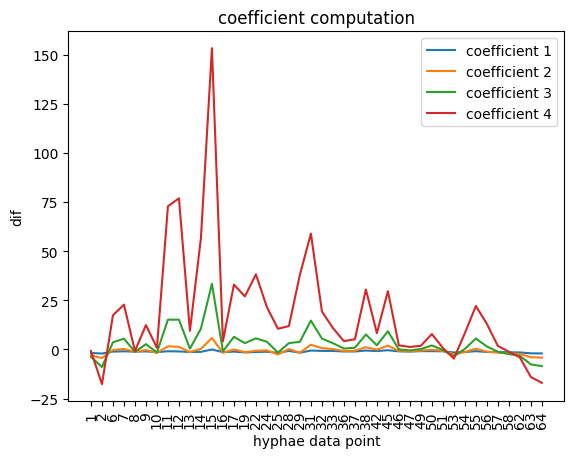

In [28]:
def coefficient_finding(mh1,dh1,dh2,coefficient):
    return (mh1/2)**coefficient-(dh1/2)**coefficient-(dh2/2)**coefficient
mh1 = get_hypha_info(main_res,[0,100])[0]
dh1 = get_hypha_info(daughter1_res,[0,100])[0]
dh2 = get_hypha_info(daughter2_res,[0,100])[0]
for i in range(1,5):
    plt.plot(coefficient_finding(mh1,dh1,dh2,i),label=f"coefficient {i}")
plt.title("coefficient computation")
plt.xlabel("hyphae data point")
plt.ylabel("dif")
plt.xticks(np.arange(0,len(main_res),1),get_hypha_info(main_res,[0,100])[1],rotation = 90)
plt.legend()
# plt.savefig("plot_data/murray's rule/coefficient_check.png")

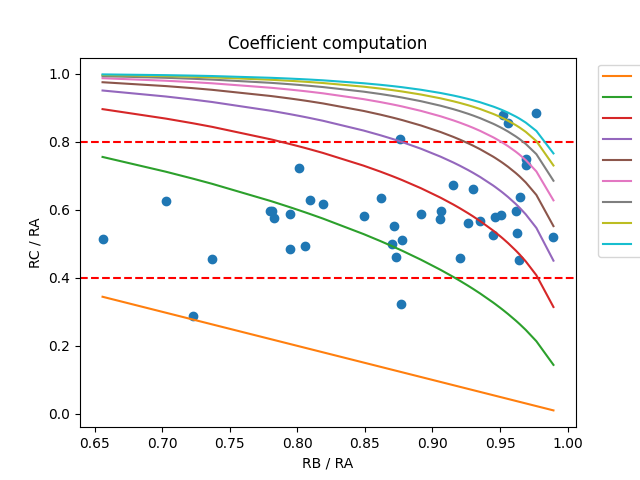

In [57]:
%matplotlib widget
x = dh1/mh1
y = dh2/mh1
plt.plot(x,y,"o")
plt.xlabel("RB / RA")
plt.ylabel("RC / RA")
x.sort()
plt.axhline(0.8,color = "r",linestyle= "--")
plt.axhline(0.4,color = "r",linestyle= "--")
for i in range(1,10):
    plt.plot(x,(1-x**i)**(1/i),label=f'power {i}')
plt.title("Coefficient computation")
plt.legend(bbox_to_anchor=(1.03, 1),loc='upper left')
plt.savefig("plot_data/murray's rule/Coefficient_check_different_power.png",bbox_inches="tight")

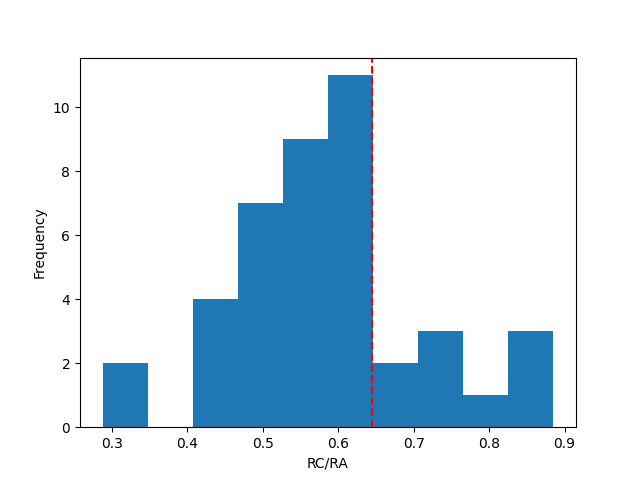

In [60]:
%matplotlib widget
mh = np.array(mh1)
dh1 = np.array(dh1)
dh2 = np.array(dh2)
plt.hist(dh2/mh,bins=10)
plt.axvline(0.645,color = "r",linestyle= "--")
plt.xlabel("RC/RA")
plt.ylabel("Frequency")
plt.savefig("plot_data/murray's rule/Ground_truth_hist.png",bbox_inches="tight")

In [40]:
ratio = dh2/mh

In [43]:
np.where(ratio<0.6)

(array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
        22, 23, 25, 26, 27, 28, 29, 30, 34, 35, 36]),)

In [44]:
mh[3]

2.596052660633303

In [ ]:
# plot the murray by the model's result prediction's.

In [45]:
get_hypha_info(main_res,[0,100])[0]


array([5.33514067, 5.09672987, 5.11860556, 5.19210532, 4.48747515,
       4.82371337, 5.01480109, 6.79537454, 6.97691774, 6.33916961,
       6.58345353, 7.6375256 , 5.72974678, 6.1611973 , 6.22952677,
       7.11033843, 5.68053855, 6.67853915, 4.74285237, 7.02194816,
       6.14144899, 4.75839394, 4.3089899 , 4.29135998, 4.03057657,
       5.9175672 , 4.44355243, 5.02263088, 3.97442556, 4.14768466,
       3.6629119 , 4.1598186 , 3.32405036, 4.41512224, 5.68577408,
       5.11743823, 5.55249713, 4.66471873, 4.93750471, 4.44183456,
       4.97255273, 4.7731529 ])

In [46]:
main_res

{1: (5.335140673465174, 'focus1D'),
 2: (5.096729871593014, 'D'),
 6: (5.118605562865291, 'top'),
 7: (5.192105321266606, 'D'),
 8: (4.487475152669089, 'D'),
 9: (4.823713368638635, 'D'),
 10: (5.014801085370462, 'top'),
 11: (6.795374544159621, 'D'),
 12: (6.976917743235791, 'D'),
 13: (6.339169606731782, 'D'),
 14: (6.583453526998798, 'top'),
 15: (7.637525601085848, 'top'),
 16: (5.729746780870368, 'D'),
 17: (6.16119729702714, 'D'),
 19: (6.229526767127777, 'D'),
 22: (7.1103384349532766, 'D'),
 24: (5.680538549130845, 'top'),
 25: (6.678539152288823, 'D'),
 28: (4.742852366984828, 'D'),
 29: (7.021948158393189, 'D'),
 31: (6.1414489882410095, 'D'),
 32: (4.758393941850271, 'D'),
 33: (4.308989903813287, 'D'),
 36: (4.291359979486507, 'D'),
 37: (4.030576567271207, 'D'),
 38: (5.9175671981595075, 'D'),
 42: (4.443552429130558, 'D'),
 45: (5.022630878468604, 'D'),
 46: (3.9744255583781545, 'D'),
 47: (4.1476846649118455, 'D'),
 49: (3.66291189735178, 'D'),
 50: (4.159818600289128, '